In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,Normalize

from scipy.stats import mode, entropy
from scipy import interpolate
from scipy.spatial.distance import jensenshannon
import helper as hp

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rmse_(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
    
def average_deviation(predictions, targets):
    return np.sum(np.abs(predictions - targets))/len(predictions)

def calc_E(all_sols, idx_to_plot):
    
    # Find average deviation
    E_df = pd.DataFrame(columns = ['solution_id', 'E_biomass', 'E_glc'])
    
    for sol_id in idx_to_plot:
    
        this_sol = all_sols[all_sols['solution_id']==sol_id]
        store_df_vals = []
        store_df_vals.append(sol_id)
    
        for conc, scaling in dict_scaling.items():
    
            #load experimental data
            exp_ = exp_data[conc]
            mean = exp_[exp_.columns[1]]
            time_exp = exp_[exp_.columns[0]]
            
            #interpolate simulated data to experimental time
            #if time_exp.values[-1]<this_sol['time'].values[-1]:
                
            f = interpolate.interp1d(this_sol['time'].values, this_sol[conc].values*scaling)
            simulated_interp = f(time_exp.values)
            #calculate rms error between experimental and interpolated simulated data
            this_E = average_deviation(mean.values, simulated_interp)
            store_df_vals.append(this_E)
    
            #else: store_df_vals.append(None)
        
        E_df.loc[sol_id] = store_df_vals

    return E_df

def plot_bioreactor(path_to_sol):
    
    all_sols= pd.read_csv(path_to_sol)
    all_sol_ids = np.unique(all_sols['solution_id'])
    
    ## Find models that finished integration and get their final biomasses
    
    all_plot_ix = []
    all_fin_biomasses = []
    for ix in all_sol_ids:
        ix_time = all_sols[all_sols['solution_id'] == ix]['time'].values
        if len(ix_time) == len(T): 
            all_plot_ix.append(ix)
            this_fin_biomass = all_sols[all_sols['solution_id'] == ix]['biomass_strain_1'].values[-1]
            all_fin_biomasses.append(this_fin_biomass*dict_scaling['biomass_strain_1'])
    
    #figure
    
    fig = plt.figure(figsize = (12,4)) 
    plot_ix = 1
    for conc, scaling in list(dict_scaling.items()):
    
        #load experimental data
        exp_ = exp_data[conc]
        mean = exp_[exp_.columns[1]]
        time_exp = exp_[exp_.columns[0]]
    
        plt.subplot(1,2,plot_ix)
    
        # Plot simulated data
        for sol_id in all_plot_ix:
            this_sol = all_sols[all_sols['solution_id']==sol_id]
            if len(this_sol[conc])==N_STEPS:
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)
                
        # Plot experimental data
        if len(exp_.columns) > 2:
            lo = exp_[exp_.columns[2]]
            hi = exp_[exp_.columns[3]]
            plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                         fmt='ko', capsize=5)
        else:
            plt.plot(time_exp, mean, 'ko')  
            plt.xlabel('time (h)')
            plt.ylabel(labels[conc], fontsize = 15)
            plt.xlim([0, 12])
    
        plot_ix+=1
        
    #plt.savefig(f'{plot_path}/sim_{ss_idx}_{rep}_{gen}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
    plt.legend()
    plt.show()
    plt.close()

def deprecautionize(x):
    if len(x) % 3 != 0:
        raise ValueError("The length of the input array must be divisible by 3.")
    
    x = np.array(x)  # Ensure the input is a numpy array
    modes = []
    
    for i in range(0, len(x), 3):
        chunk = x[i:i+3]
        modes.append(mode(chunk).mode[0])  # Compute the mode of the chunk and append
    return np.array(modes)

class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=50, clip=False):
        super().__init__(vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        # Apply a custom normalization formula
        result = (value - self.vmin) / (self.vmax - self.vmin)  # Scale to 0-1
        result = np.interp(result, [0, 0.5, 1], [0, self.midpoint, 1])  # Custom mapping
        return result

In [3]:
TOTAL_TIME = 15
N_STEPS = 100

T = np.linspace(0, TOTAL_TIME, N_STEPS)
T_start_ix = np.where(T<0.9603)[-1][-1]

growth = pd.read_csv('exp_data/biomass.csv')
glc = pd.read_csv('exp_data/glucose.csv')
dict_scaling = {'biomass_strain_1': 0.28e-12, 'glc_D_e': 1e-6}#, 'ac_e': 1e-6,
                #'etoh_e': 1e-6, 'for_e': 1e-6} # 1e-6 because we need to present the results in  (mM)
labels = {'biomass_strain_1': 'biomass (g/L)', 'glc_D_e': 'glucose (mM)'}#, 'ac_e': 'acetate (mM)',
          #'etoh_e': 'ethanol (mM)', 'for_e': 'formate (mM)'}
exp_data = {'biomass_strain_1': growth, 'glc_D_e': glc}#, 'ac_e': ac, 'etoh_e': eth, 'for_e': form}

all_exp_mets = [growth, glc]
final_exp_val = []
for this_met in all_exp_mets:
    final_exp_val.append(this_met.iloc[:,1].values[-1])
    
final_exp_ss = {}
for ix, key in enumerate(list(dict_scaling.keys())):
    final_exp_ss[key] = final_exp_val[ix]

# Model indexes
ss_idx = 3709
repeat = 1
gen = 23
valid_idx_og = 82

names_km = pd.read_csv(f'../models/varma_ecoli_anaerobic/parameter_names_km_fdp1.csv').iloc[:,1].values
n_kms = len(names_km)

## load og solution
og_sols = pd.read_csv(f'samples/{ss_idx}/{repeat}/sample_{gen}.csv')
og_eigs = pd.read_csv(f'samples/{ss_idx}/{repeat}/sample_{gen}_max_eigs.csv').iloc[:,1].values
reverse_valid_idx = np.where(np.where(og_eigs<=-0.9)[0] == valid_idx_og)[0][0]
og_sol = og_sols[og_sols['solution_id'] == reverse_valid_idx]

### Check bioreactor responses for all augmented models

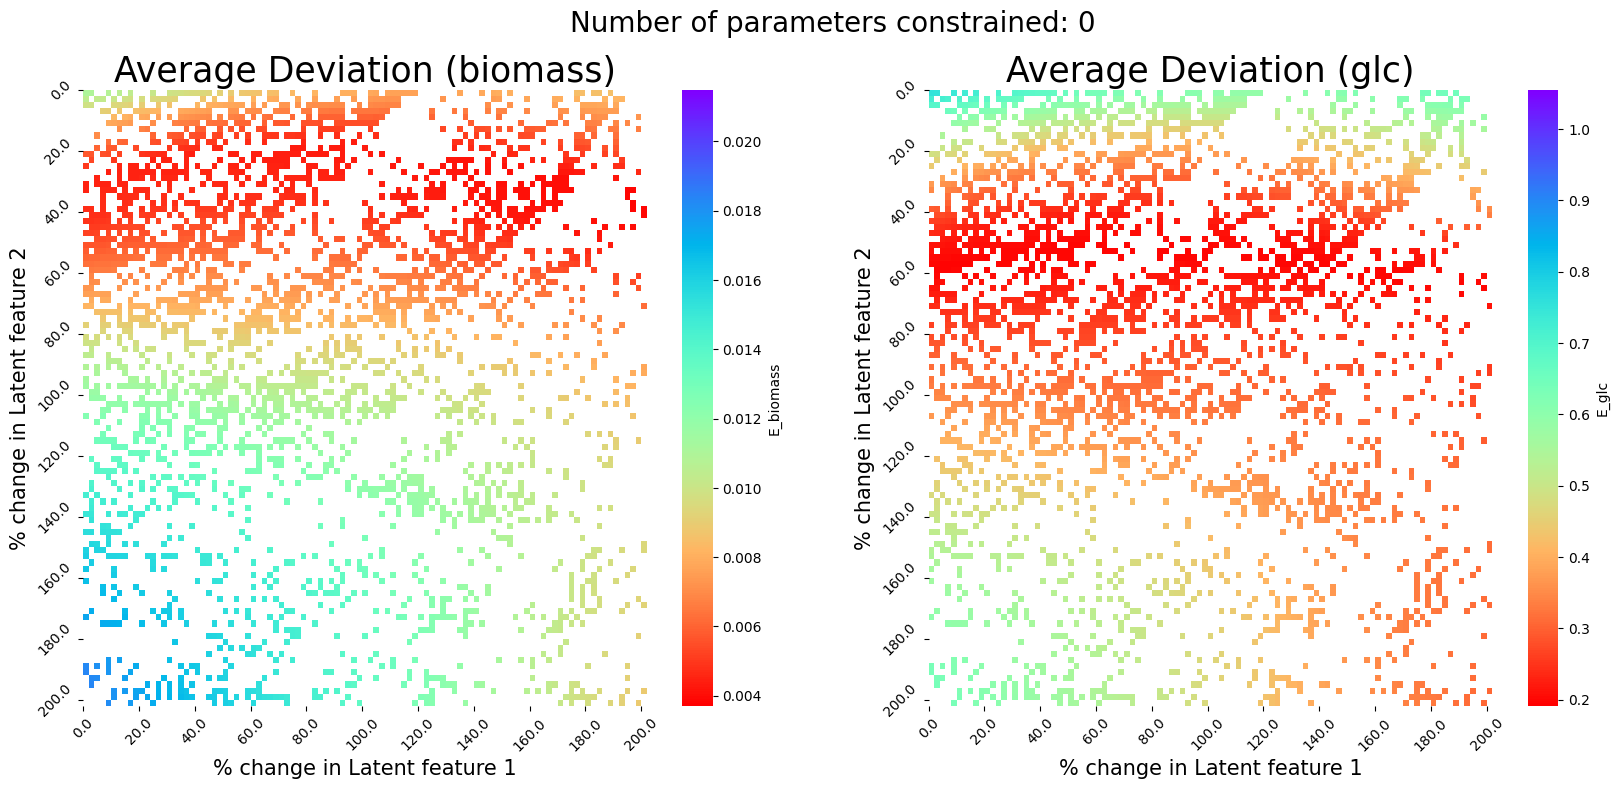

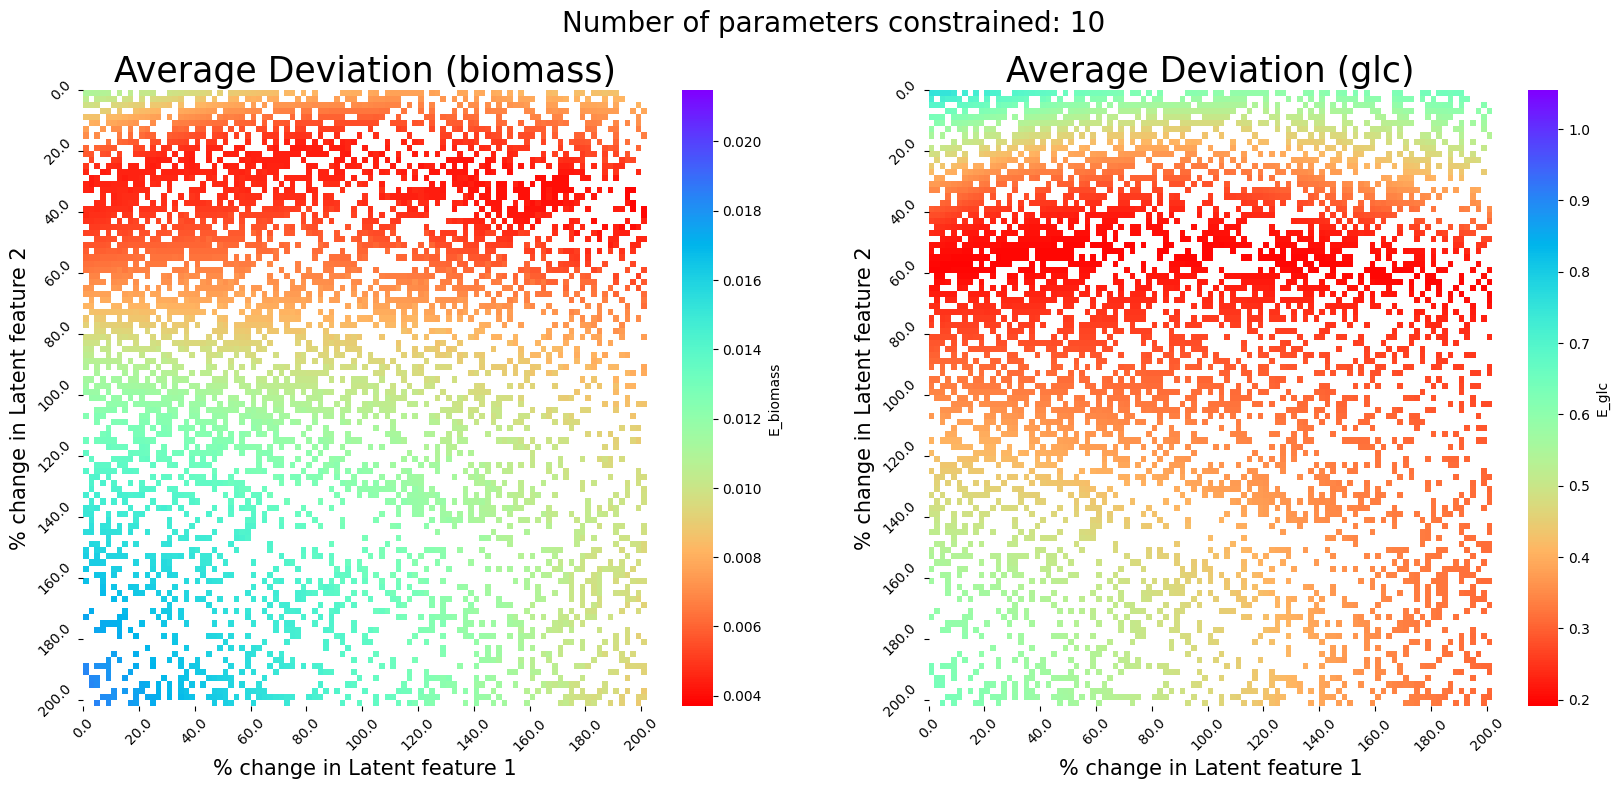

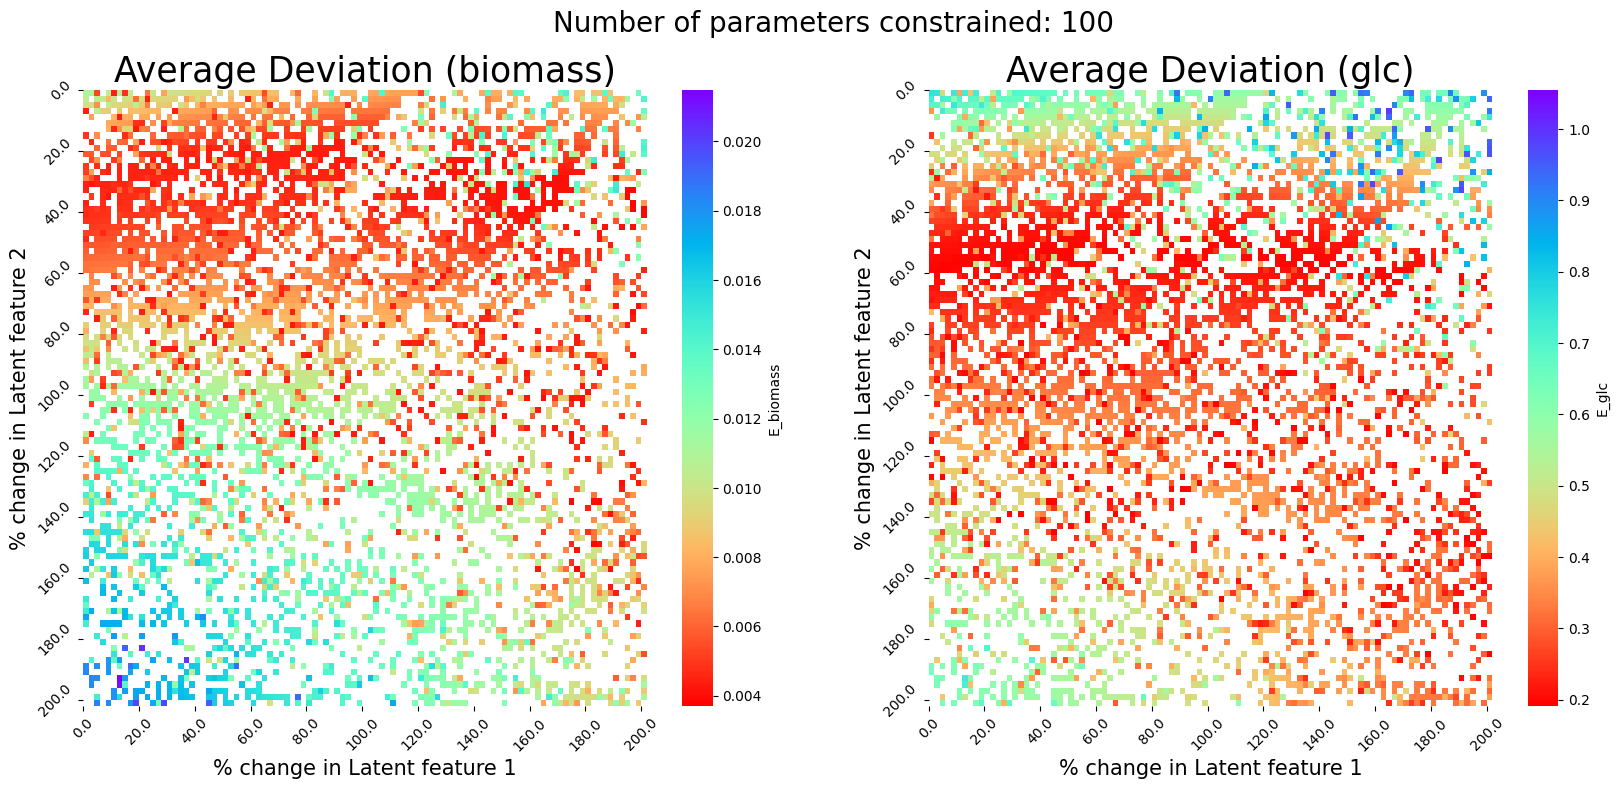

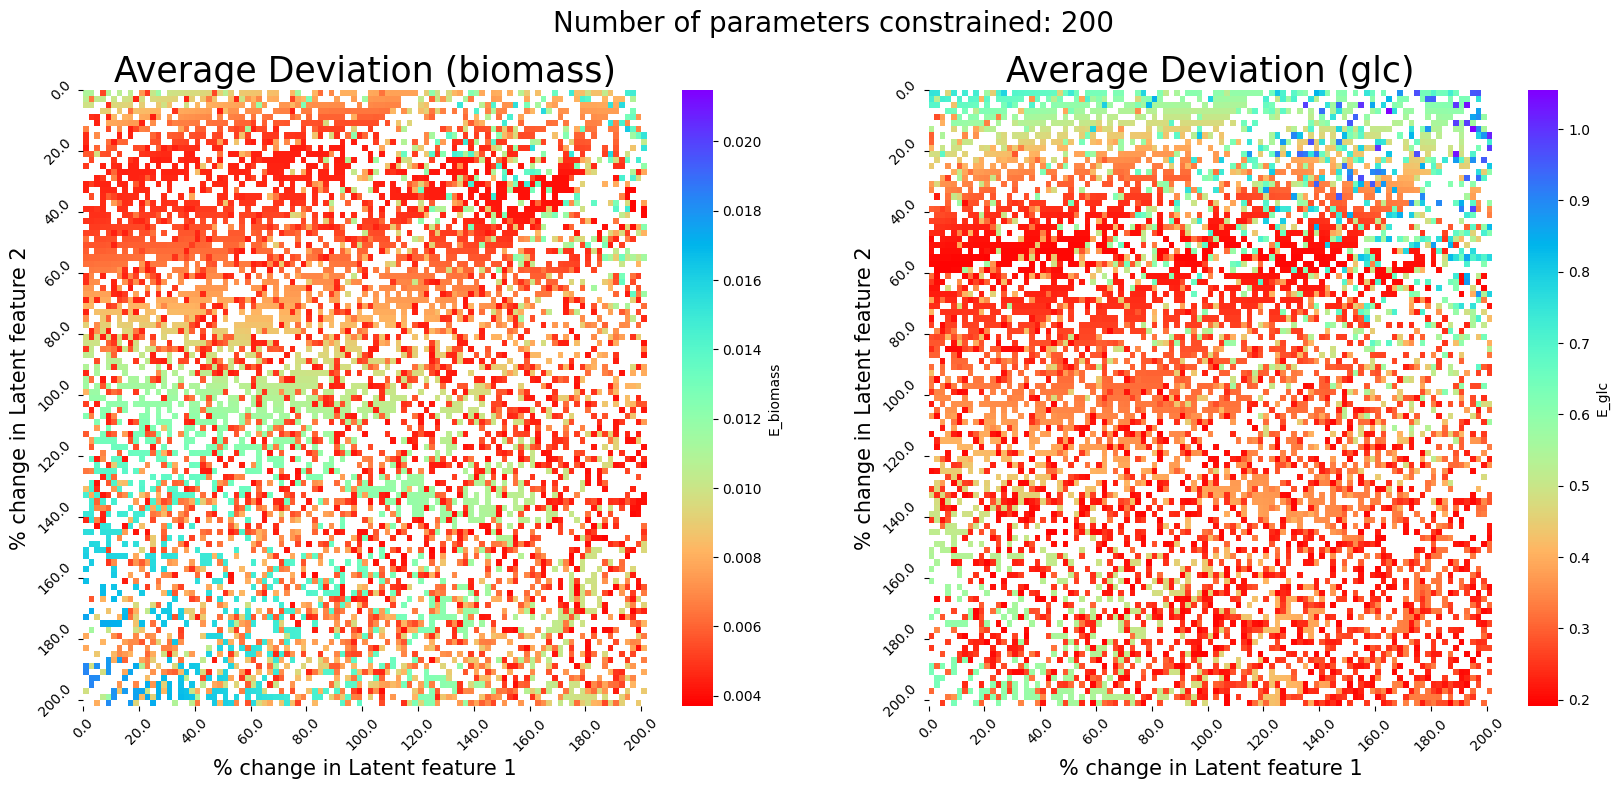

In [4]:
n_consts = [0,10,100,200]
all_E_glc = []
all_E_biomass = []
global_E_biomass_min, global_E_biomass_max = float('inf'), float('-inf')
global_E_glc_min, global_E_glc_max = float('inf'), float('-inf')

# Precompute global min and max values for consistent colorbars
for n_const in n_consts:
    name_ = f'new_sample_{n_const}_0.3'
    path_to_sol = f'augmentation/{name_}.csv'
    sols = pd.read_csv(f'{path_to_sol}')
    sol_ids = np.unique(sols['solution_id'])

    eigs = pd.read_csv(f'augmentation/{name_}_max_eigs.csv').iloc[:, 1].values

    E_biomass = []
    E_glc = []
    
    for ix in range(len(eigs)):
        if eigs[ix] < 0:
            ix_time = sols[sols['solution_id'] == ix]['time'].values
            if len(ix_time) == len(T):
                E_df = calc_E(sols[sols['solution_id'] == ix], [ix])
                E_biomass.append(E_df['E_biomass'].values[0])
                E_glc.append(E_df['E_glc'].values[0])
            else:
                E_biomass.append(-1000)
                E_glc.append(-1000)
        else:
            E_biomass.append(-1000)
            E_glc.append(-1000)

    E_biomass = np.array(E_biomass)
    E_glc = np.array(E_glc)

    # Update global min and max
    E_biomass_valid = E_biomass[E_biomass >= 0]
    E_glc_valid = E_glc[E_glc >= 0]
    
    if len(E_biomass_valid) > 0:
        global_E_biomass_min = min(global_E_biomass_min, np.min(E_biomass_valid))
        global_E_biomass_max = max(global_E_biomass_max, np.max(E_biomass_valid))
    if len(E_glc_valid) > 0:
        global_E_glc_min = min(global_E_glc_min, np.min(E_glc_valid))
        global_E_glc_max = max(global_E_glc_max, np.max(E_glc_valid))

# Plot with consistent colorbars
for n_const in n_consts:
    name_ = f'new_sample_{n_const}_0.3'
    path_to_sol = f'augmentation/{name_}.csv'
    sols = pd.read_csv(f'{path_to_sol}')
    sol_ids = np.unique(sols['solution_id'])

    eigs = pd.read_csv(f'augmentation/{name_}_max_eigs.csv').iloc[:, 1].values

    E_biomass = []
    E_glc = []

    for ix in range(len(eigs)):
        if eigs[ix] < 0:
            ix_time = sols[sols['solution_id'] == ix]['time'].values
            if len(ix_time) == len(T):
                E_df = calc_E(sols[sols['solution_id'] == ix], [ix])
                E_biomass.append(E_df['E_biomass'].values[0])
                E_glc.append(E_df['E_glc'].values[0])
            else:
                E_biomass.append(-1000)
                E_glc.append(-1000)
        else:
            E_biomass.append(-1000)
            E_glc.append(-1000)

    E_biomass = np.array(E_biomass)
    E_glc = np.array(E_glc)

    E_biomass[E_biomass < 0] = np.nan
    E_glc[E_glc < 0] = np.nan

    E_biomass_mat = np.reshape(E_biomass, (101, 101))
    E_glc_mat = np.reshape(E_glc, (101, 101))

    plt.figure(figsize=(20, 8))

    # Plot E_biomass heatmap
    plt.subplot(121)
    custom_norm = CustomNormalize(vmin=global_E_biomass_min, vmax=global_E_biomass_max, midpoint=0.006)
    sns.heatmap(
        E_biomass_mat, cmap='rainbow_r',
        cbar_kws={'label': 'E_biomass'},
        vmin=global_E_biomass_min, vmax=global_E_biomass_max,
        #norm = custom_norm
    )
    plt.xticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
    plt.yticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
    plt.xlabel('% change in Latent feature 1', fontsize=15)
    plt.ylabel('% change in Latent feature 2', fontsize=15)
    plt.title('Average Deviation (biomass)', fontsize=25)

    # Plot E_glc heatmap
    plt.subplot(122)
    custom_norm = CustomNormalize(vmin=global_E_glc_min, vmax=global_E_glc_max, midpoint=0.8)
    sns.heatmap(
        E_glc_mat, cmap='rainbow_r',
        cbar_kws={'label': 'E_glc'},
        vmin=global_E_glc_min, vmax=global_E_glc_max,
        # norm = custom_norm
    )
    plt.xticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
    plt.yticks(np.arange(101)[::10], np.linspace(0, 200, num=101)[::10], rotation=45)
    plt.xlabel('% change in Latent feature 1', fontsize=15)
    plt.ylabel('% change in Latent feature 2', fontsize=15)
    plt.title('Average Deviation (glc)', fontsize=25)

    plt.suptitle(f'Number of parameters constrained: {n_const}', fontsize=20)
    
    plt.savefig(f'figures/E_{n_const}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
    plt.savefig(f'figures/E_{n_const}.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
    
    plt.show()
    plt.close()


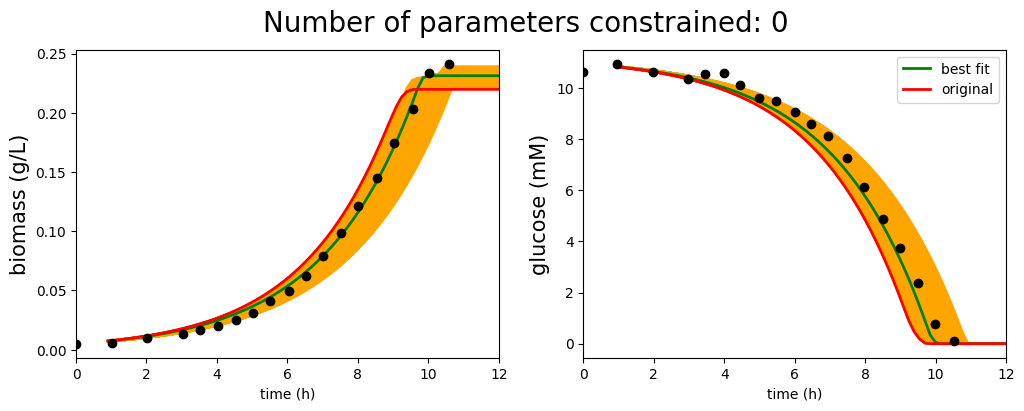

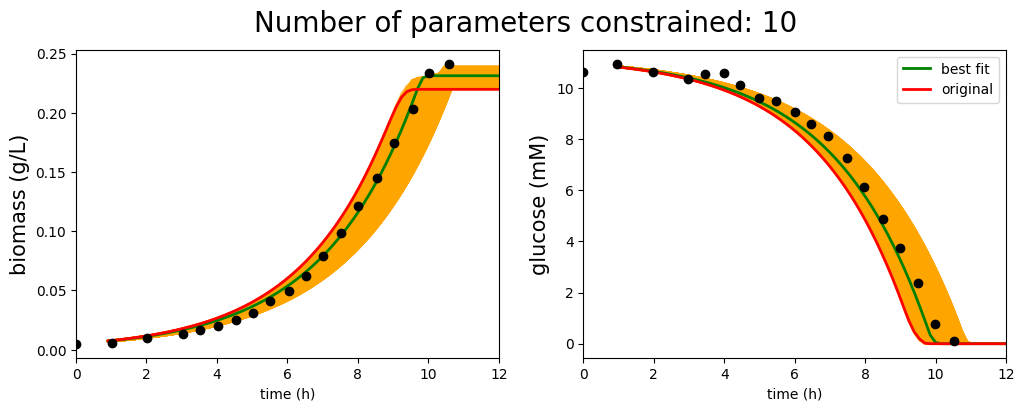

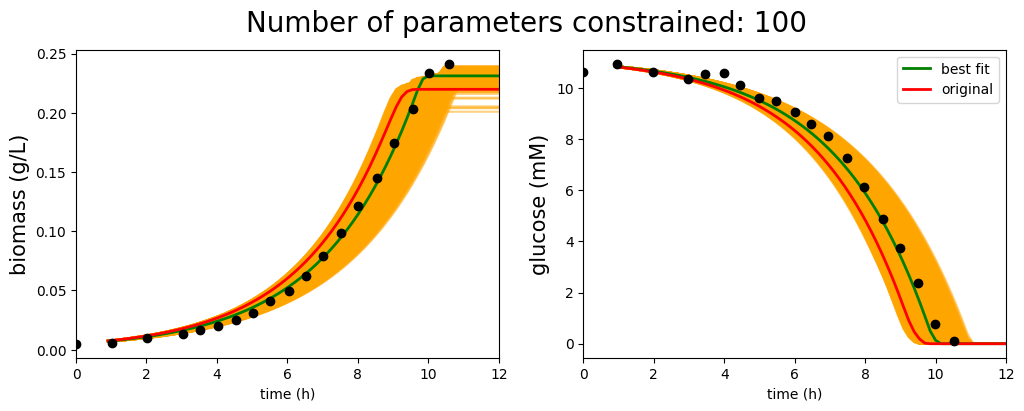

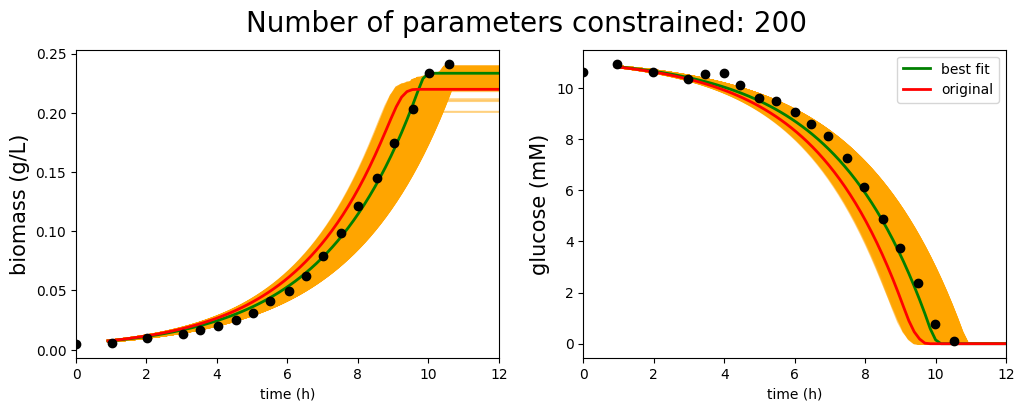

In [6]:
for n_const in n_consts:

    name_ = f'new_sample_{n_const}_0.3'
    path_to_sol = f'augmentation/{name_}.csv'
    sols  = pd.read_csv(f'{path_to_sol}')
    sol_ids = np.unique(sols['solution_id'])

    eigs = pd.read_csv(f'augmentation/{name_}_max_eigs.csv').iloc[:,1].values

    all_plot_ix = []
    all_final_biomasses = []
    E_biomass = []
    E_glc = []
    
    for ix in range(len(eigs)):

        if eigs[ix]<0:
            
            ix_time = sols[sols['solution_id'] == ix]['time'].values

            if len(ix_time) == len(T):

                #select for plotting
                all_plot_ix.append(ix)

                #get final_biomass
                this_final_biomass = sols[sols['solution_id'] == ix]['biomass_strain_1'].values[-1]
                all_final_biomasses.append(this_final_biomass*dict_scaling['biomass_strain_1'])

                # get average_deviations for biomass and glucose
                E_df = calc_E(sols[sols['solution_id'] == ix], [ix])
                E_biomass.append(E_df['E_biomass'].values[0])
                E_glc.append(E_df['E_glc'].values[0])

            else:
                all_final_biomasses.append(-1000)
                E_biomass.append(-1000)
                E_glc.append(-1000)
                
        else:

            all_final_biomasses.append(-1000)
            E_biomass.append(-1000)
            E_glc.append(-1000)

    E_biomass = np.array(E_biomass)
    E_glc = np.array(E_glc)
    all_final_biomasses = np.array(all_final_biomasses)

    E_biomass[E_biomass < 0] = np.nan
    E_glc[E_glc < 0] = np.nan
    all_final_biomasses[all_final_biomasses < 0] = np.nan

    

    #calculate best fit model
    n = 10
    w_ = 0.5
    w = [w_, 1-w_]
    E_biomass = np.array(w[0]*E_biomass/np.nanmax(E_biomass) + w[1]/(all_final_biomasses/np.nanmax(all_final_biomasses)))
    best_ix = np.where(E_biomass == np.nanmin(E_biomass))[0][0]
    #valid_indexes = np.where(~np.isnan(E_biomass))[0]
    #sorted_valid_indexes = valid_indexes[np.argsort(E_biomass[valid_indexes])]
    #n_min_indexes = sorted_valid_indexes[:n]
    
    #figure
    
    fig = plt.figure(figsize = (12,4)) 
    plot_ix = 1
    for conc, scaling in list(dict_scaling.items()):
    
        #load experimental data
        exp_ = exp_data[conc]
        mean = exp_[exp_.columns[1]]
        time_exp = exp_[exp_.columns[0]]
    
        plt.subplot(1,2,plot_ix)
    
        # Plot simulated data
        for sol_id in all_plot_ix:
            this_sol = sols[sols['solution_id']==sol_id]
            if len(this_sol[conc])==N_STEPS:
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)
                
         
        E_df = calc_E(sols, all_plot_ix)
        
        # Find solution with the lowest biomass E and its corresponding E_glc
        min_E_biomass = E_df['E_biomass'].min() # minimum E_biomass
        ix_min_E_biomass = int(E_df[E_df['E_biomass'] == min_E_biomass]['solution_id'].values[0])

        #max_final_biomass = 
        # Plot best fit
        for this_ix in [best_ix]:
            this_sol = sols[sols['solution_id']== this_ix] #ix_min_E_biomass]
            plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'green', label = 'best fit')
        
        # Plot original
        plt.plot(T[T_start_ix:], og_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'red', label = 'original')
        
        
        # Plot experimental data
        if len(exp_.columns) > 2:
            lo = exp_[exp_.columns[2]]
            hi = exp_[exp_.columns[3]]
            plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                         fmt='ko', capsize=5)
        else:
            plt.plot(time_exp, mean, 'ko')  
            plt.xlabel('time (h)')
            plt.ylabel(labels[conc], fontsize = 15)
            plt.xlim([0, 12])
    
        plot_ix+=1
        
    plt.suptitle(f'Number of parameters constrained: {n_const}', fontsize = 20)
    
    plt.savefig(f'figures/sim_{n_const}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
    plt.savefig(f'figures/sim_{n_const}.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
    
    plt.legend()
    plt.show()
    plt.close()

### Figure Plots

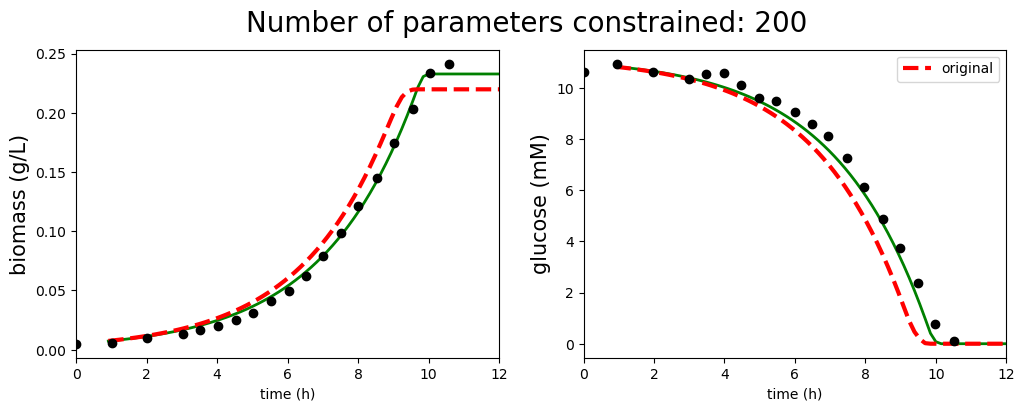

In [74]:
E_biomass[E_biomass < 0] = np.nan
E_glc[E_glc < 0] = np.nan
these_ixs = np.where(E_biomass == np.nanmin(E_biomass))[0]

plot_ix = 1
fig = plt.figure(figsize = (12,4)) 

for conc, scaling in list(dict_scaling.items()):

    #load experimental data
    exp_ = exp_data[conc]
    mean = exp_[exp_.columns[1]]
    time_exp = exp_[exp_.columns[0]]
    
    plt.subplot(1,2,plot_ix)
    
    # Plot simulated data
    for sol_id in these_ixs:
        this_sol = sols[sols['solution_id']==sol_id]
        if len(this_sol[conc])==N_STEPS:
            plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'green', lw = 2, alpha = 1)
    
    # Plot original
    plt.plot(T[T_start_ix:], og_sol[conc][T_start_ix:]*scaling, lw = 3, ls = '--',  color = 'red', label = 'original')

    
    # Plot experimental data
    if len(exp_.columns) > 2:
        lo = exp_[exp_.columns[2]]
        hi = exp_[exp_.columns[3]]
        plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                     fmt='ko', capsize=5)
    else:
        plt.plot(time_exp, mean, 'ko')  
        plt.xlabel('time (h)')
        plt.ylabel(labels[conc], fontsize = 15)
        plt.xlim([0, 12])

    plot_ix+=1

plt.suptitle(f'Number of parameters constrained: {n_const}', fontsize = 20)
plt.savefig(f'best.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
plt.legend()
plt.show()
plt.close()

In [80]:
(0.753-0.330)/(0.753)

0.5617529880478087

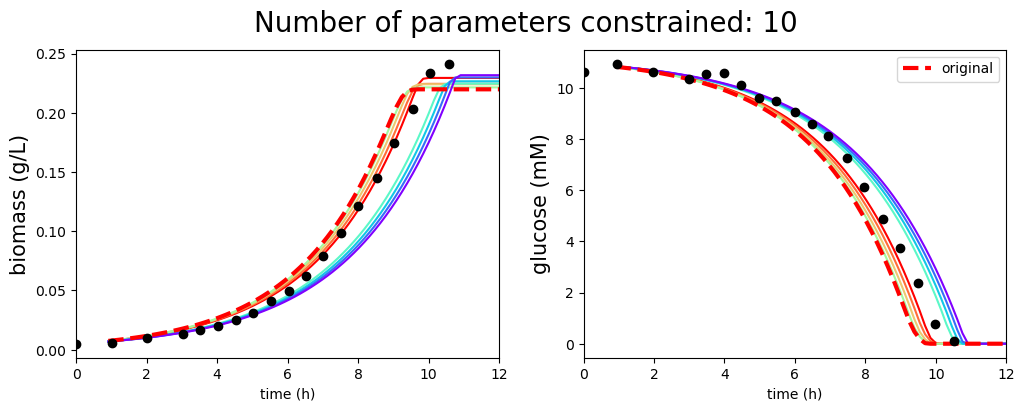

In [52]:
n_plots = 1
targets = np.arange(0.004, 0.020, 0.002)
tol = 0.01
points = []

#get colors
n  = len(targets)
cmap = plt.get_cmap('rainbow_r')
colors = [cmap(i / (n - 1)) for i in range(n)]

for this_target in targets:
    this_ix = np.intersect1d(np.where(E_biomass > this_target*(1-tol))[0], np.where(E_biomass< this_target*(1+tol))[0])
    points.append(this_ix)

plot_ix = 1
fig = plt.figure(figsize = (12,4)) 

for conc, scaling in list(dict_scaling.items()):

    #load experimental data
    exp_ = exp_data[conc]
    mean = exp_[exp_.columns[1]]
    time_exp = exp_[exp_.columns[0]]
    
    plt.subplot(1,2,plot_ix)
    
    # Plot simulated data
    for color, these_ixs in zip(colors,points):
        for sol_id in these_ixs[:n_plots]:
            this_sol = sols[sols['solution_id']==sol_id]
            if len(this_sol[conc])==N_STEPS:
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = color, alpha = 1)
            
    
    
    # Plot original
    plt.plot(T[T_start_ix:], og_sol[conc][T_start_ix:]*scaling, lw = 3, ls = '--',  color = 'red', label = 'original')
    
    
    # Plot experimental data
    if len(exp_.columns) > 2:
        lo = exp_[exp_.columns[2]]
        hi = exp_[exp_.columns[3]]
        plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                     fmt='ko', capsize=5)
    else:
        plt.plot(time_exp, mean, 'ko')  
        plt.xlabel('time (h)')
        plt.ylabel(labels[conc], fontsize = 15)
        plt.xlim([0, 12])

    plot_ix+=1
    
    
plt.suptitle(f'Number of parameters constrained: {n_const}', fontsize = 20)

plt.savefig(f'RAINBOW.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
plt.legend()
plt.show()
plt.close()
